In [ ]:
%pip install basemap
%pip install basemap-data-hires
%pip3 install torch
%pip3 install pqdm

<ipython-input-13-ced139e599ab>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, sst[0], vmin=0.01, vmax=30)


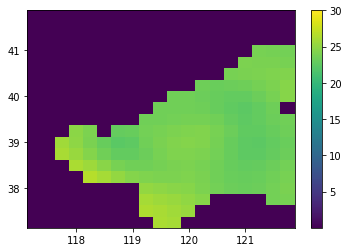

(14732, 20, 20)


In [13]:
# Data preparation
import torch
import torch.nn as nn
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import sys

# Get training data
ds = nc.Dataset("./data/sst.bohai.day.mean.1981-2021.nc")

latitudes = ds.variables['lat']
longitudes = ds.variables['lon']
sst = np.clip(np.array(ds.variables['sst']), a_min=0.01, a_max=None)
X, Y = np.meshgrid(longitudes[:], latitudes[:])

plt.figure()
plt.pcolor(X, Y, sst[0], vmin=0.01, vmax=30)
plt.colorbar()
plt.show()

print(sst.shape)

In [14]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
class FCLSTM(nn.Module):
  def __init__(self, input_size=25, hidden_size=25, history_length=4, prediction_length=1, device='cpu'): 
    super(FCLSTM, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    
    self.history_length = history_length
    self.prediction_length = prediction_length

    self.device = device

    self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
    self.fc_layer = nn.Linear(history_length * hidden_size, prediction_length * hidden_size)
    self.relu = nn.ReLU()

  # takes in a grid of N x history_length x 25 and returns a grid of N x prediction_length x 5 x 5 
  def forward(self, input, reshape=True):
      num_samples = input.shape[0]
      h_t = torch.zeros(1, num_samples, self.hidden_size).to(self.device)
      c_t = torch.zeros(1, num_samples, self.hidden_size).to(self.device)

      output, (h_t, c_t) = self.lstm_layer(input, (h_t, c_t)) # output: N x history_length x 25
      output = torch.flatten(output, start_dim=1) # = N x history_length * 25
      output = self.fc_layer(output) # = N x prediction_length * 25
      if reshape:
        output = torch.reshape(output, (num_samples, self.prediction_length, int(np.sqrt(self.hidden_size)), int(np.sqrt(self.hidden_size)))) # N x prediction_length x 5 x 5

      output = self.relu(output)
      return output

In [5]:
class CFCCLSTM(FCLSTM):
  def __init__(self, input_size=25, hidden_size=25, history_length=4, prediction_length=1, device="cpu", mode="weighted"): 
    super(CFCCLSTM, self).__init__(input_size, hidden_size, history_length, prediction_length, device)

    self.conv_layer = nn.Conv1d(prediction_length,prediction_length, kernel_size=hidden_size, stride=1, padding=0)
    if mode == "average":
      self.conv_layer = nn.Conv1d(prediction_length,prediction_length, kernel_size=hidden_size, stride=1, padding=0)
      with torch.no_grad():
        self.conv_layer.weight.data = torch.mul(torch.ones(1, 1, hidden_size), 1.0 / hidden_size)
        self.conv_layer.weight.requires_grad = False

  # takes in a grid of N x history_length x 25 and returns a grid of N x prediction_length x 5 x 5 
  def forward(self, input):
      output = super().forward(input, False) # N x prediction_length x 5 x 5

      # put data in 1 channel
      output = torch.unsqueeze(output, dim=1) # N x 1 x 25
      output = self.conv_layer(output) # N x 1 x 1
      output = torch.flatten(output, start_dim=1)

      return output

In [6]:
class FCLSTM_SSTPredictor:
    def __init__(self, sst, model, history_length, prediction_length, batch_size, device="cpu", epochs = 50):
        self.sst = sst
        self.sequence_length = self.sst.shape[0]
        self.history_length = history_length
        self.prediction_length = prediction_length
        self.batch_size = batch_size
        self.device = device
        self.epochs = epochs

        self.model = model.to(self.device)

    def transform_data(self, data):
        x = []
        y = []

        data_length = data.shape[0]

        for t in range(data_length - self.history_length - self.prediction_length):
            for lat in range(16):
                for lon in range(16):
                    x.append(
                        self.sst[t:t + self.history_length, lat:lat+5, lon:lon+5]
                    )
                    y.append(
                        self.sst[t + self.history_length:t + self.history_length + self.prediction_length, lat:lat+5, lon:lon+5]
                    )
        
        x_tensor = torch.Tensor(np.asarray(x)).flatten(start_dim=2)
        y_tensor = torch.Tensor(np.asarray(y))

        return x_tensor, y_tensor

    def train_test(self, split=4/5):
        return self.sst[:int(len(self.sst) * split), :, :], self.sst[int(len(self.sst) * split):, :, :]

    def make_batches(self, x, y):
        return list(zip(x.split(self.batch_size), y.split(self.batch_size)))

    def criterion(self, output, target):
        return torch.sqrt(nn.MSELoss()(output, target))
    
    def accuracy(self, output, target):
        return 1 - torch.mean(torch.divide(torch.subtract(output, target)), target)

    def train(self, batches):
        print("Running training...")
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)

        losses = []
        accuracies = []

        
        for i in range(self.epochs):
  
            if len(losses) > 0:
                sys.stdout.write('\r'+ "Current iteration: " + str(i) + ", previous loss: " + str(losses[len(losses) - 1]) + ", previous accuracy: " + str(accuracies[len(accuracies) - 1]) + "\n")
                sys.stdout.flush()

            sumLosses = []
            sumAccuracies = []

            for batch in batches:
                # Randomly initialize hidden
                train_input = batch[0].to(self.device)
                train_target = batch[1].to(self.device)

                optimizer.zero_grad()
                output = self.model(train_input) # batch_size x prediction_length x 5 x 5

                loss = self.criterion(output, train_target)
                accuracy = self.accuracy(output, train_target)

                sumLosses.append(loss.item())
                sumAccuracies.append(accuracy.item())

                loss.backward()
                optimizer.step() 

            losses.append(np.mean(sumLosses))
            accuracies.append(np.nanmean(sumAccuracies))
        
        return losses, accuracies

    def test(self, batches):
        print("Running test...")

        sumLosses = []
        sumAccuracies = []

        with torch.no_grad():
            for batch in batches:
                test_input = batch[0].to(self.device)
                test_target = batch[1].to(self.device)
                output = self.model(test_input) # batch_size x prediction_length x 5 x 5

                loss = self.criterion(output, test_target)
                accuracy = self.accuracy(output, test_target)

                sumLosses.append(loss.item())
                sumAccuracies.append(accuracy.item())

        return sumLosses, sumAccuracies
    
    def train_plot(self, losses, accuracies):        
        plt.title("Loss (RMSE)")
        plt.plot(list(range(0, self.epochs)), losses)
        plt.figure()
        plt.title("Accuracy")
        plt.plot(list(range(0, self.epochs)), accuracies)

    def test_plot(self, losses, accuracies):
        print("RMSE for validation:", np.mean(losses))
        print("Accuracy for validation:", np.mean(accuracies))



Running training...
Current iteration: 1, previous loss: 5.632003721493614, previous accuracy: -74.0746600092773
Current iteration: 2, previous loss: 3.6811613662993765, previous accuracy: -80.1268179257171
Current iteration: 3, previous loss: 2.9706554166276913, previous accuracy: -62.93273009345163
Current iteration: 4, previous loss: 2.542147299323503, previous accuracy: -48.73107506376778
Current iteration: 5, previous loss: 2.2543801206684275, previous accuracy: -39.49184768021815
Current iteration: 6, previous loss: 2.042212977878914, previous accuracy: -32.73813655105228
Current iteration: 7, previous loss: 1.875360563518843, previous accuracy: -27.55837604590709
Current iteration: 8, previous loss: 1.7372586889360069, previous accuracy: -23.580782830006804
Current iteration: 9, previous loss: 1.6247848084149012, previous accuracy: -20.56559784084508
Current iteration: 10, previous loss: 1.5320271677598483, previous accuracy: -18.21292127741213
Current iteration: 11, previous lo

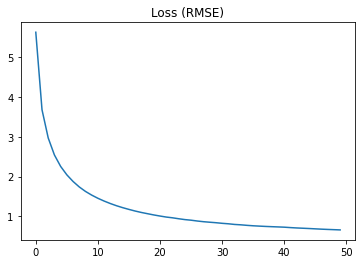

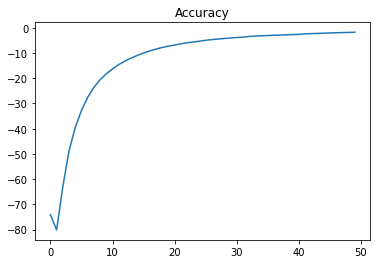

In [15]:
model = FCLSTM(25, 25, 4, 1, device=device)

sst_predictor = FCLSTM_SSTPredictor(sst, model, 4, 1, 1024, epochs=50, device=device)
train_data, test_data = sst_predictor.train_test()

x_train, y_train = sst_predictor.transform_data(train_data)
train_batches = sst_predictor.make_batches(x_train, y_train)

x_test, y_test = sst_predictor.transform_data(test_data)
test_batches = sst_predictor.make_batches(x_test, y_test)

train_loss, train_accuracy = sst_predictor.train(train_batches)
sst_predictor.train_plot(train_loss, train_accuracy)

test_loss, test_accuracy = sst_predictor.test(test_batches)
sst_predictor.test_plot(test_loss, test_accuracy)

In [11]:
class CFCCLSTM_SSTPredictor(FCLSTM_SSTPredictor):   

    def transform_data(self, data):
        x = []
        y = []

        data_length = data.shape[0]

        for t in range(data_length - self.history_length - self.prediction_length):
            for lat in range(16):
                for lon in range(16):
                    x.append(
                        self.sst[t:t + self.history_length, lat:lat+5, lon:lon+5]
                    )
                    y.append(
                        self.sst[t + self.history_length:t + self.history_length + self.prediction_length, lat, lon]
                    )
        
        x_tensor = torch.Tensor(np.asarray(x)).flatten(start_dim=2)
        y_tensor = torch.Tensor(np.asarray(y))

        return x_tensor, y_tensor

<ipython-input-8-c282197a9b55>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  x_tensor = torch.Tensor(x).flatten(start_dim=2)


Running training...
Current iteration: 1, previous loss: 7.712312317117542, previous accuracy: -24.44488104022279
Current iteration: 2, previous loss: 5.270625566138702, previous accuracy: -37.25045245520923
Current iteration: 3, previous loss: 3.822917561547286, previous accuracy: -27.598155809908498
Current iteration: 4, previous loss: 2.9272194612188405, previous accuracy: -22.25800395336281
Current iteration: 5, previous loss: 2.462779796751989, previous accuracy: -17.94499626775988
Current iteration: 6, previous loss: 2.1819735892167706, previous accuracy: -15.35796903185293
Current iteration: 7, previous loss: 1.980991668999195, previous accuracy: -13.250761639504205
Current iteration: 8, previous loss: 1.8301479003461851, previous accuracy: -11.513433306395601
Current iteration: 9, previous loss: 1.7107336530271842, previous accuracy: -9.77035877818153
Current iteration: 10, previous loss: 1.6216894843850007, previous accuracy: -8.404892410550799
Current iteration: 11, previous 

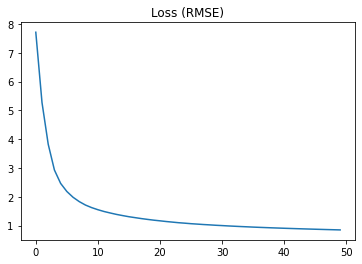

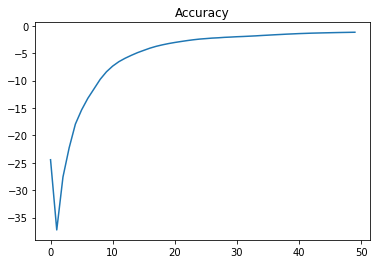

In [9]:
model = CFCCLSTM(25, 25, 4, 1, device=device)

sst_predictor = CFCCLSTM_SSTPredictor(sst, model, 4, 1, 1024, epochs=50, device=device)
train_data, test_data = sst_predictor.train_test()

x_train, y_train = sst_predictor.transform_data(train_data)
train_batches = sst_predictor.make_batches(x_train, y_train)

x_test, y_test = sst_predictor.transform_data(test_data)
test_batches = sst_predictor.make_batches(x_test, y_test)

train_loss, train_accuracy = sst_predictor.train(train_batches)
sst_predictor.train_plot(train_loss, train_accuracy)

test_loss, test_accuracy = sst_predictor.test(test_batches)
sst_predictor.test_plot(test_loss, test_accuracy)

Running training...
Current iteration: 1, previous loss: 7.975011036915033, previous accuracy: -18.70532994205449
Current iteration: 2, previous loss: 6.3416732342875735, previous accuracy: -31.02378362214484
Current iteration: 3, previous loss: 5.3534079265026815, previous accuracy: -21.76505117675885
Current iteration: 4, previous loss: 4.637049623391255, previous accuracy: -16.42849349651207
Current iteration: 5, previous loss: 4.06538008710965, previous accuracy: -13.770742142281565
Current iteration: 6, previous loss: 3.593031343148679, previous accuracy: -12.106198732544776
Current iteration: 7, previous loss: 3.201744785012842, previous accuracy: -11.327236542085402
Current iteration: 8, previous loss: 2.877015470748856, previous accuracy: -10.898623048042765
Current iteration: 9, previous loss: 2.6060626270616947, previous accuracy: -10.637340740281708
Current iteration: 10, previous loss: 2.3808515825036434, previous accuracy: -10.389578488408302
Current iteration: 11, previou

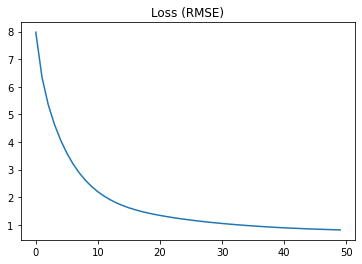

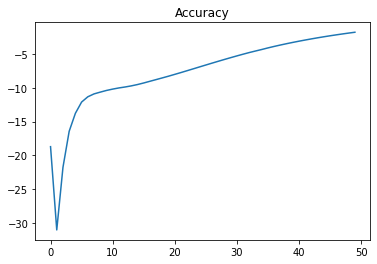

In [10]:
model = CFCCLSTM(25, 25, 4, 1, mode="average", device=device)

sst_predictor = CFCCLSTM_SSTPredictor(sst, model, 4, 1, 1024, epochs=50, device=device)
train_data, test_data = sst_predictor.train_test()

x_train, y_train = sst_predictor.transform_data(train_data)
train_batches = sst_predictor.make_batches(x_train, y_train)

x_test, y_test = sst_predictor.transform_data(test_data)
test_batches = sst_predictor.make_batches(x_test, y_test)

train_loss, train_accuracy = sst_predictor.train(train_batches)
sst_predictor.train_plot(train_loss, train_accuracy)

test_loss, test_accuracy = sst_predictor.test(test_batches)
sst_predictor.test_plot(test_loss, test_accuracy)

In [ ]:
import matplotlib

# Plot a prediction for CFCC LSTM

input =  sst[:20, :, :] # 20 x 20 x 20

prediction_input = []
for latitude in range(2, 18):
    for longitude in range(2,18):
      input_values = input[:, latitude - 2: latitude + 3, longitude - 2: longitude + 3] # history_length x 5 x 5 
      prediction_input.append(input_values)

print(np.asarray(prediction_input).shape)

ground_truth = np.asarray(sst[20:27, 2:18, 2:18]) # 7 x 16 x 16

tensor_input = torch.from_numpy(np.asarray(prediction_input)).to(device) # N x 20 1
tensor_input = torch.flatten(tensor_input, start_dim=2) # N x 20 x 25
print("input shape: ", tensor_input.shape)

output = model(tensor_input) # N x 7 x 25
output = output.transpose(0,1)
print("output shape", output.shape)
output = torch.reshape(output, (7, 16,16))
print("output shape", output.shape)

predicted_days = np.asarray(output.tolist())
print(predicted_days.shape)

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(28, 4))
for i, day in enumerate(predicted_days):
  im = axes[i].pcolor(day, vmin=0.01, vmax=30)

fig.subplots_adjust(right=2)

cb_ax = fig.add_axes([1.00, 0.1, 0.005, 0.85])
cbar = fig.colorbar(im, cax=cb_ax)
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(28, 4))
for i, day in enumerate(ground_truth):
  im = axes[i].pcolor(day, vmin=0.01, vmax=30)

fig.subplots_adjust(right=2)

cb_ax = fig.add_axes([1.00, 0.1, 0.005, 0.85])
cbar = fig.colorbar(im, cax=cb_ax)
fig.tight_layout()
plt.show()


differences = np.abs(np.subtract(ground_truth, predicted_days))

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(28, 4))
for i, day in enumerate(differences):
  im = axes[i].pcolor(day, vmin=0, vmax=5, cmap="Greys")

fig.subplots_adjust(right=2)

cb_ax = fig.add_axes([1.00, 0.1, 0.005, 0.85])
cbar = fig.colorbar(im, cax=cb_ax)
fig.tight_layout()
plt.show()